# Lesson 5: Semantic segmentation with geospatial data


In this notebook we will learn how to use deep learning algorithms to analyze geospatial data.
For this purpose we will use one of the most known deep learning library, pytorch.
We will also take advantage of torchgeo which is particularly useful for doing machine learning when geospatial data is involved
In particular we will see how to download a dataset, visualize the data, train a model and do predictions.

It is recommanded to run the following notebook on a gpu to reduce training times.

In [1]:
# import libraries
import os
import rasterio
from tqdm import tqdm
import numpy as np
import tempfile
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch import no_grad
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

For this notebook we're going to use the NAIP (National Agriculture Imagery Program) dataset https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ
and we will combine it with the Chesapeake Land cover map https://www.chesapeakeconservancy.org/conservation-innovation-center/high-resolution-data/land-cover-data-project/

The NAIP dataset contains aerial imagery during the agricultural growing seasons in the continental U.S. This imagery is acquired at one-meter ground sample distance with a geoaccuracy of 6 meters.

The Chesapeake land cover map contains high-resolution land cover labels from the Chesapeake Bay watershed which includes the states of: New York, Pennsylvania, West Virginia, Maryland, Delaware, Virginia, and the District of Columbia.
Each pixel in the land cover map is labelled according to a different land cover type as described in https://cicwebresources.blob.core.windows.net/docs/LC%20Class%20Description.pdf

In [2]:
# Let's download some tiles from the naip dataset
# intro taken from:
# https://github.com/microsoft/torchgeo/blob/main/docs/tutorials/getting_started.ipynb

In [3]:
# select device, check if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# download some naip data tiles
naip_root = os.path.join(tempfile.gettempdir(), "naip_train")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    "m_3807511_se_18_060_20181104.tif",
    "m_3807512_nw_18_060_20180815.tif"
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)

naip_train = NAIP(naip_root)

Using downloaded and verified file: C:\Users\degas\AppData\Local\Temp\naip_train\m_3807511_ne_18_060_20181104.tif
Using downloaded and verified file: C:\Users\degas\AppData\Local\Temp\naip_train\m_3807511_se_18_060_20181104.tif
Using downloaded and verified file: C:\Users\degas\AppData\Local\Temp\naip_train\m_3807512_nw_18_060_20180815.tif


In [5]:
# let's open one of the downloaded tiles and print some information about it
with rasterio.open(os.path.join(tempfile.gettempdir(), "naip_train", "m_3807511_ne_18_060_20181104.tif")) as src:
    raster = src.read()
    print("raster resolution:", src.res)
    print("source crs:", src.crs)
    print("raster shape:", raster.shape)

raster resolution: (0.6, 0.6)
source crs: EPSG:26918
raster shape: (4, 12531, 10050)


We can observe that downloaded tiles are pretty big and they have a resolution of 0.6 meters and are projected in the EPSG:26918

We can see how we can subsample those tiles to have more date on which we can train our model

In [6]:
# download some naip data tiles
naip_root = os.path.join(tempfile.gettempdir(), "naip_val")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807512_sw_18_060_20180815.tif"
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)

naip_val = NAIP(naip_root)

Using downloaded and verified file: C:\Users\degas\AppData\Local\Temp\naip_val\m_3807512_sw_18_060_20180815.tif


In [7]:
# let's download chesapeake land cover map
chesapeake_root = os.path.join(tempfile.gettempdir(), "chesapeake")
os.makedirs(chesapeake_root, exist_ok=True)
chesapeake = ChesapeakeDE(chesapeake_root, crs=naip_train.crs, res=naip_train.res, download=True)

In [8]:
os.path.join(tempfile.gettempdir(), "chesapeake")

'C:\\Users\\degas\\AppData\\Local\\Temp\\chesapeake'

In [9]:
print(f"Downloaded scenes naip train {len(naip_train)}")

Downloaded scenes naip train 3


In [10]:
print(f"Downloaded scenes naip validation {len(naip_val)}")

Downloaded scenes naip validation 1


In [11]:
# create intersection datataset between the naip downloaded scenes and the corresponding area in the chesapeake dataset
train_dataset = naip_train & chesapeake

In [12]:
# do the same for validation
val_dataset = naip_val & chesapeake

In [13]:
len(train_dataset)

3

In [14]:
len(val_dataset)

1

In [47]:
# Set the ratio for splitting into training and validation sets the total number of samples
train_ratio = 0.8  # 80% for training, 20% for validation
# we're going to select only 20 samples for this showcases because I've only cpu available on my laptop. 
# If you have gpu you could train your model on a larger set of data improving the results
total_samples = 20 # samples number after augmentation
train_size = int(train_ratio * total_samples)
val_size = total_samples - train_size

In [35]:
# PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset 
# that allow you to use pre-loaded datasets as well as your own data. 
# Dataset stores the samples and their corresponding labels, and 
# DataLoader wraps an iterable around the Dataset to enable easy access to the samples
# This helps readability and modularity

# We will use the RandomGeoSampler
# It samples elements from a region of interest randomly.
# This is particularly useful during training when you want to maximize the size of the dataset 
# and return as many random chips as possible. Note that randomly sampled chips may overlap.
sampler = RandomGeoSampler(train_dataset, size=300, length=train_size)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=16, collate_fn=stack_samples)
sampler = RandomGeoSampler(val_dataset, size=300, length=val_size)
val_loader = DataLoader(val_dataset, sampler=sampler, batch_size=16, collate_fn=stack_samples)

In [36]:
# let's check train and validation dataloader sizes after applying the RandomGeoSampler

In [37]:
len(train_loader)

1

In [38]:
len(val_loader)

1

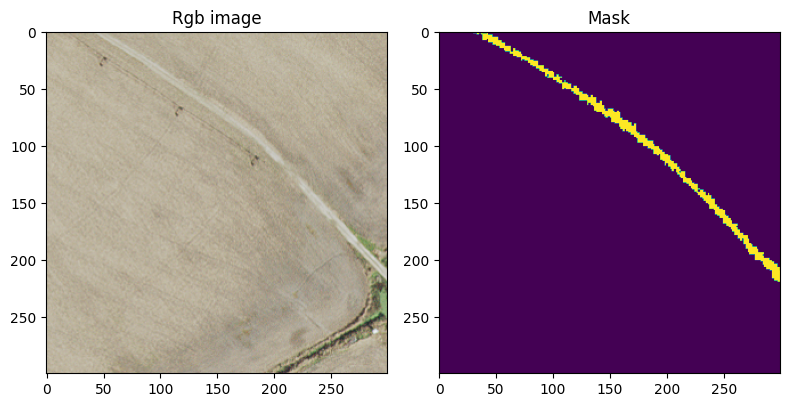

In [39]:
# let's print a random element of the training dataset
random_element = np.random.randint(0, len(train_loader))
for idx, sample in enumerate(train_loader):
    if idx != random_element:
        continue
    
    # let's select the first sample from the batch
    image = sample["image"][0]
    target = sample["mask"][0]
    
    # Create a figure and a 1x2 grid of axes
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the first image in the left axis
    # select only first 3 bands and cast to uint8
    rgb_image = np.transpose(image.numpy().squeeze()[0:3], (1, 2, 0)).astype('uint8')
    axes[0].imshow(rgb_image)
    axes[0].set_title('Rgb image')

    # Plot the labels image in the right axis
    target_image = target.numpy().squeeze()
    axes[1].imshow(target_image)
    axes[1].set_title('Mask')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()

# Training

In this notebook we will train a Unet (source https://github.com/milesial/Pytorch-UNet?tab=readme-ov-file) network to do image segmentation over the downloaded geospatial data.

U-Net is a convolutional neural network architecture designed for image segmentation tasks. Its U-shaped structure includes a contracting path for feature extraction and downsampling, a bottleneck layer for abstract feature representation, and an expansive path for upsampling and detailed feature reconstruction. Notable for its extensive use of skip connections, U-Net links corresponding layers in the contracting and expansive paths to preserve fine details. The final layer employs a 1x1 convolution with a sigmoid activation for pixel-wise classification, generating a segmentation map.

The following image represents the architecture from the original paper https://arxiv.org/abs/1505.04597:

 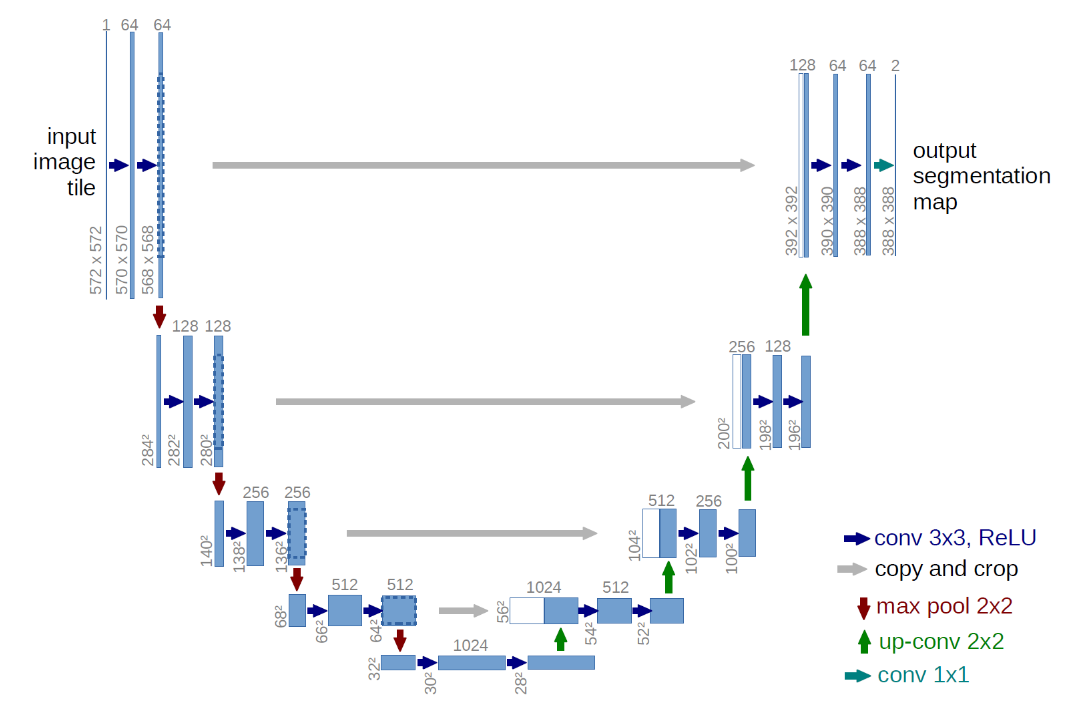

In [40]:
# let's build the unet model, code taken from https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [41]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [42]:
nb_channels = 3  # Adjust according to your input data channels (we will use onyl the rg channels)
nb_classes = 13 # Number of classes in the label images
model = UNet(n_channels=nb_channels, n_classes=nb_classes)
model = model.to(device)

# let's define criteria to calculate the loss as well as the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
# Training loop

# Set the number of epochs for training, we're going to save and use the model
# that will have the smaller loss after a given epoch
num_epochs = 10
log_dict = {'loss_per_batch': [], 'loss_per_epoch': []}
best_loss = 9999999
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs = batch["image"][:,0:3,:,:] #let's select only first 3 channels
        targets = batch["mask"]
        
        # if gpu available this will move the data on the gpu
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze(1))  # Squeeze the channel dimension in labels
        log_dict['loss_per_batch'].append(loss.data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluation phase
    model.eval()
    total_val_loss = 0.0

    # In the evaluation phase we do not recalculate gradients for training
    with torch.no_grad():
        # calculate the loss over the validation samples
        for val_batch in val_loader:
            inputs = val_batch["image"][:,0:3,:,:] #let's select only first 3 channels
            targets = val_batch["mask"]

            # if gpu available this will move the data on the gpu
            val_inputs = inputs.to(device)
            val_targets = targets.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets.squeeze(1))
            total_val_loss += val_loss.item()

    # calculate the average loss 
    average_val_loss = total_val_loss / len(val_loader)
    log_dict['loss_per_epoch'].append(average_val_loss)
    
    # Check if current performance is better than the best so far by checking the average_val_loss on the validation set
    if average_val_loss < best_loss:
        best_loss = average_val_loss
        # Save the model checkpoint
        torch.save(model.state_dict(), 'best_model.pt')

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {average_val_loss}")

Epoch 1/10, Training Loss: 2.549734592437744, Validation Loss: 2.443878650665283
Epoch 2/10, Training Loss: 2.4388926029205322, Validation Loss: 1.4802520275115967
Epoch 3/10, Training Loss: 1.8444545269012451, Validation Loss: 1.4984732866287231
Epoch 4/10, Training Loss: 1.1760605573654175, Validation Loss: 0.48678797483444214
Epoch 5/10, Training Loss: 0.9603961706161499, Validation Loss: 1.0065253973007202
Epoch 6/10, Training Loss: 0.9654274582862854, Validation Loss: 1.687757968902588
Epoch 7/10, Training Loss: 0.9333682060241699, Validation Loss: 1.495403528213501
Epoch 8/10, Training Loss: 1.356522798538208, Validation Loss: 2.0233023166656494
Epoch 9/10, Training Loss: 0.8298099040985107, Validation Loss: 1.6762324571609497
Epoch 10/10, Training Loss: 1.0692954063415527, Validation Loss: 1.553587555885315


In [44]:
# Once you have saved the best model you can load it without having to retrain
model = UNet(n_channels=nb_channels, n_classes=nb_classes)
# I'll use here a model that I've trained a little bit on gpu
# training such a model on cpu would require too long
# you can use the model trained in this notebook by replacing 'best_model_gpu.pt' with 'best_mode.pt'

# We're going to use a model that I've trained on the cloud
# that model was trained for about 100 rpochs on 400 samples and validated on 100
# results can be improved by considering a large set of data
state_dict = torch.load('best_model_gpu.pt', map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)

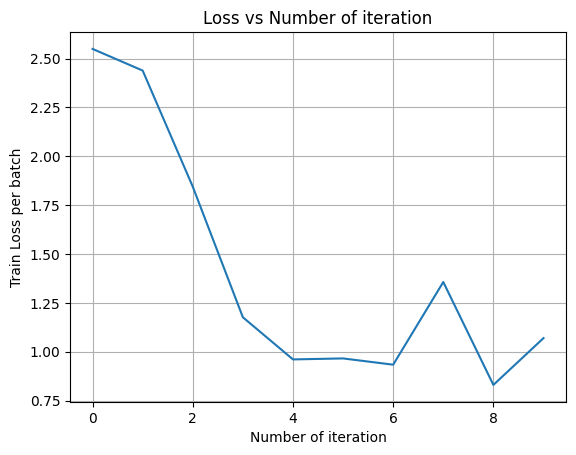

In [45]:
# visualization loss per batch
loss_values = [float(t.cpu().numpy()) for t in log_dict['loss_per_batch']]
plt.plot(log_dict['loss_per_batch'])
plt.xlabel("Number of iteration")
plt.ylabel("Train Loss per batch")
plt.title("Loss vs Number of iteration")
plt.grid()
plt.show()

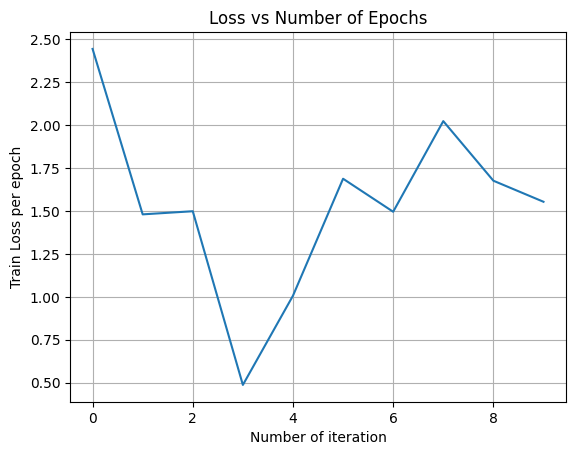

In [46]:
# visualization loss per epoch
plt.plot(log_dict['loss_per_epoch'])
plt.xlabel("Number of iteration")
plt.ylabel("Train Loss per epoch")
plt.title("Loss vs Number of Epochs")
plt.grid()
plt.show()

In [28]:
# let's evaluate the model on a single image and plot the predicted mask
model.eval()  # Set the model to evaluation mode

# get the first batch to do evaluation
for idx, batch in enumerate(val_loader):
    inputs = batch["image"][:,0:3,:,:] #let's select only first 3 channels
    targets = batch["mask"]
    
    # if gpu available this will move the data on the gpu
    inputs = inputs.to(device)
    targets = targets.to(device)

with torch.no_grad():
    # Forward pass
    outputs = model(inputs)
    
    # Calculate loss
    loss = criterion(outputs, targets.squeeze(1))

    # Convert logits to predicted class labels
    predicted_masks = torch.argmax(outputs, dim=1)

# Further evaluation metrics can be calculated based on your task

# Optionally, print or use the calculated metrics
print("Loss on the single validation sample:", loss.item())

Loss on the single validation sample: 0.4996170103549957


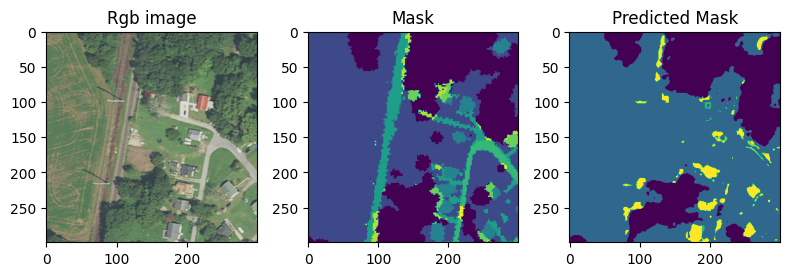

In [29]:
# Create a figure and a 1x2 grid of axes
fig, axes = plt.subplots(1, 3, figsize=(8, 4))

# Plot the first image in the left axis
rgb_image = np.transpose(inputs.cpu().numpy().squeeze()[0:3][0], (1, 2, 0)).astype('uint8')
axes[0].imshow(rgb_image)
axes[0].set_title('Rgb image')

# Plot the second image in the right axis
target_image = targets.cpu().numpy().squeeze()[0]
axes[1].imshow(target_image)
axes[1].set_title('Mask')

# Plot the predictions
predicted_mask = predicted_masks.cpu().numpy().squeeze()[0]
axes[2].imshow(predicted_mask)
axes[2].set_title('Predicted Mask')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

We can compare the predicted mask (rightmost image) with the labels (image at the center). We can observe how the model has started to learn how to recognise classes as for the class in dark blue. We could still improve the results by training longer the model and/or by implentating more advanced techniques to avoid overfitting or to evaluate the best model.